In [10]:
import torch 
from matplotlib  import pyplot as plt
# 绘制曲线
def plot_curve(data):
    fig = plt.figure()
    plt.legend(['value'],loc = 'upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()

#  绘制图片
def plot_image(img,label,name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0] * 0.3081 + 0.1307,cmap = 'gray')
        plt.title("{}:{}".format(name,label[i].item()))
        plt.xticks([])
        plt.yticks([])

    plt.show()

# one hot编码
def one_hot(label,depth = 10):
    out = torch.zeros(label.size(0),depth)
    idx = torch.LongTensor(label).view(-1,1)
    out.scatter_(dim = 1,index = idx ,value = 1)
    return out


In [11]:
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from matplotlib import pyplot as plt


#  加载数据集  batch_size表示每次取出512张图片
batch_size = 512
#  torchvision.transforms.Normalize((0.1307,),(0.3081,)) 表示归一化操作
# torchvision.transforms.ToTensor() 表示将numpy张量 转换为tensor
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('minst_data',
                                                                      train = True,
                                                                      download=True,
                                                                      transform=torchvision.transforms.
                                                                      Compose([torchvision.transforms.ToTensor(),
                                                                               torchvision.transforms.Normalize((0.1307,),(0.3081,))])),
                                                                               batch_size=batch_size,shuffle = True)


#  加载测试数据集
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('minst_data',
                                                                      train = False,
                                                                      download=True,
                                                                      transform=torchvision.transforms.
                                                                      Compose([torchvision.transforms.ToTensor(),
                                                                               torchvision.transforms.Normalize((0.1307,),(0.3081,))])),
                                                                               batch_size=batch_size,shuffle = False)

torch.Size([512, 1, 28, 28]) torch.Size([512])


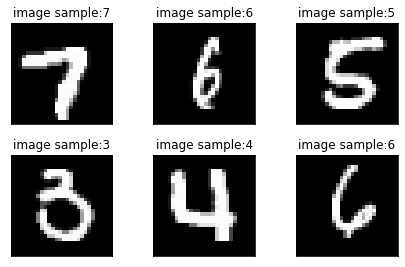

In [12]:
x,y = next(iter(train_loader))

#  输出 512 1 28 28 也就是512张图片  1 通道 28 x 28大小
print(x.shape,y.shape)

plot_image(x,y,'image sample')

In [13]:
#  编写网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        # xw + b
        self.fc1 = nn.Linear(28 * 28,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

In [14]:
net = Net()
# 定义优化器
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum=0.9)

# 保存训练损失
train_loss = []
for epoch in range(3):
    for batch_idx,(x,y) in enumerate(train_loader):
        #  将 [b,1,28,28] 转换成 [b.feature] 二维的tensor

        x = x.view(x.size(0),28 * 28) # 第一个参数表示图片的batch_size  

        # 最后的out形状是 [b,10] 表示每一张图片有 十个类别的概率
        out = net(x)

        # 转换为独热编码
        y_onehot = one_hot(y)

        # 计算损失
        loss = F.mse_loss(out,y_onehot)

        # 梯度清零
        optimizer.zero_grad()

        # 计算梯度
        loss.backward()

        # 更新优化
        optimizer.step()

        train_loss.append(loss.item())

        if batch_idx % 10 ==0:
            print("第{}次迭代的损失是{}".format(epoch,loss.item()))




第0次迭代的损失是0.1300497055053711
第0次迭代的损失是0.10195918381214142
第0次迭代的损失是0.08857591450214386
第0次迭代的损失是0.08089607954025269
第0次迭代的损失是0.07421528548002243
第0次迭代的损失是0.06875762343406677
第0次迭代的损失是0.06444506347179413
第0次迭代的损失是0.06162204593420029
第0次迭代的损失是0.05735468119382858
第0次迭代的损失是0.058026812970638275
第0次迭代的损失是0.05461948364973068
第0次迭代的损失是0.05312863737344742
第1次迭代的损失是0.04999012500047684
第1次迭代的损失是0.04899003356695175
第1次迭代的损失是0.04792163521051407
第1次迭代的损失是0.046678345650434494
第1次迭代的损失是0.0460270419716835
第1次迭代的损失是0.04134463146328926
第1次迭代的损失是0.045542534440755844
第1次迭代的损失是0.043115872889757156
第1次迭代的损失是0.040697939693927765
第1次迭代的损失是0.04280713573098183
第1次迭代的损失是0.04083523526787758
第1次迭代的损失是0.040383100509643555
第2次迭代的损失是0.038198117166757584
第2次迭代的损失是0.03787333890795708
第2次迭代的损失是0.038305819034576416
第2次迭代的损失是0.03706532344222069
第2次迭代的损失是0.03498927503824234
第2次迭代的损失是0.04087337851524353
第2次迭代的损失是0.03694644197821617
第2次迭代的损失是0.03592710942029953
第2次迭代的损失是0.03296944499015808
第2次迭代的损失是0.03484991937875748
第2次迭代的损失

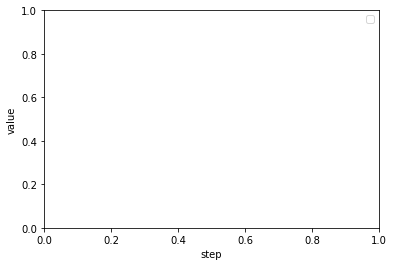

In [15]:
plot_curve(train_loss)

In [16]:
total_correct = 0

# 计算正确率
for x,y in test_loader:
    x = x.view(x.size(0),28 * 28)
    out = net(x)
    pred = out.argmax(dim = 1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num  = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:',acc)  # 测试集的正确率 0.8807

test acc: 0.8807


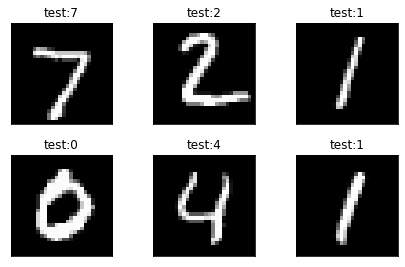

In [17]:
#  使用测试集进行测试
x,y = next(iter(test_loader))  # 从test_loader中加载出一个数据
out = net(x.view(x.size(0),28 * 28))
pred = out.argmax(dim=1)
plot_image(x,pred,'test')